0. Make sure the time windows have positive length.

1. Data instance lar 
n= 10, 15, 20, 50, 100
Her bir instance, 7 instance a donusucek.
Histogram olustur.

2. Nasil Initial tour seceriz? 

Birkac instance (2 instance 20, 50) ve birkac e_max ve T_max  (1-1, 1-0.6, 0.6-1) icin
Her bir initial tour construction icin ve her local search yontemi icin 100 replication yap. 

    i. graph ve drone u factor = 1 icin hesapla ve kaydet. 

    ii. drone factorlerini guncelle (max time ve max energy). Initial tourlari hesapla.

    iii. 


3. ratio initial tour duzelt. Ve sezgisele cevir (gidebilecegi yere kadar uzat.)


---- Exact

4. Son edge'in enerji consumptionini guncelle.  v = max(d / (t_max - t_cikis), v_opt). Her seferinde bunu guncelleyip output versin.

T_max, E_max degistikce information nasil degisiyo, taqblolastiralim. 

T_max cok arttir, run al.






Her node a karşılık gelen satır aşağıdaki verileri içerir:

     i x y d S f a list O C

i = node numarası

x = x koordinatı

y = y koordinatı
     
S = node information - bunu I_max değeri olarak alabiliriz

O = Time windowun başlangıç zamanı
     
C = Time windowun bitiş zamanı

In [ ]:
from uav_routing.environment.data import load
callibrated_path ="/Users/kirtisoglu/Documents/GitHub/UAV-Routing/uav_routing/notebooks/calibrated_env.pkl"
data = load(callibrated_path)

graph, drone = data['graph'], data['drone']

from uav_routing.environment.plot import plot_graph_with_positions
plot_graph_with_positions(graph.nodes, graph.edges)

In [ ]:
from uav_routing.local_search.initial_tour import run_detailed_experiment

run_detailed_experiment(drone, graph, k=3)

In [ ]:
from uav_routing.local_search.initial_tour import failure_reason_statistics
import pandas as pd
#failure_reason_statistics()
path = '/Users/kirtisoglu/Documents/GitHub/UAV-Routing/uav_routing/notebooks/results_k3_detailed.csv'
df = pd.read_csv(path)
print(df['failure_reason'].value_counts())
print(df['failure_reason'].value_counts(normalize=True) * 100)

failure_reason
Time_Window_Violation                 1726
JobSolveStatus.INFEASIBLE_SOLUTION      18
Name: count, dtype: int64
failure_reason
Time_Window_Violation                 98.96789
JobSolveStatus.INFEASIBLE_SOLUTION     1.03211
Name: proportion, dtype: float64


In [23]:
df

,sequence,feasible,objective,total_energy,total_dist,failure_reason,arrival_times
0,0-1-2,False,0.000000,0.000000e+00,41297.069820,Time_Window_Violation,NaN
1,0-1-3,False,0.000000,0.000000e+00,38411.608464,Time_Window_Violation,NaN
2,0-1-4,False,0.000000,0.000000e+00,39792.311969,Time_Window_Violation,NaN
3,0-1-5,False,0.000000,0.000000e+00,38056.928330,Time_Window_Violation,NaN
4,0-1-6,False,0.000000,0.000000e+00,42780.561206,Time_Window_Violation,NaN
...,...,...,...,...,...,...,...
2445,0-50-45,False,0.000000,0.000000e+00,49636.324232,Time_Window_Violation,NaN
2446,0-50-46,False,0.000000,0.000000e+00,47394.768784,Time_Window_Violation,NaN
2447,0-50-47,True,49.492020,4.759254e+07,45831.264879,NaN,"{0: 3043.8876740671217, 50: 2016.799836218904,..."
2448,0-50-48,False,0.000000,0.000000e+00,48955.743206,Time_Window_Violation,NaN


In [32]:
drone.max_energy

1180650941.2173913

In [ ]:
#Phase 2: Strategy Execution & Analysis
#This block implements the corrected T1-T4 logic and provides a summary table.

from uav_routing.local_search.initial_tour import (tour_with_nearest_neighbors,
                                      tour_with_max_ratio,
                                      random_tour,
                                      random_then_nn_tour)

def analyze_initial_strategies(graph, drone, df, tour_length=3):
    """
    Runs T1-T4 strategies and produces a comparative report.
    """
    print("--- Step 3: Generating Initial Tours (T1-T4) ---")
    
    # T1: Nearest Neighbor
    t1 = tour_with_nearest_neighbors(graph, drone, df, tour_length)
    
    # T2: Efficiency Ratio (Consumption-Based)
    # Note: We pass the DF where arrival_times are already parsed
    t2_nodes = tour_with_max_ratio(graph, drone, df, tour_length)
    t2 = None
    if t2_nodes:
        t2_seq = "-".join(map(str, t2_nodes))
        match = df[df['sequence'] == t2_seq]
        t2 = match.iloc[0] if not match.empty else None
        
    # T3: Pure Random Feasible
    t3 = random_tour(df)
    
    # T4: Vetted (Random-Start Greedy)
    t4 = random_then_nn_tour(graph, drone, df, tour_length)
    
    # Compile Results
    results = []
    methods = [("T1: Nearest Neighbor", t1), 
               ("T2: Efficiency Ratio", t2), 
               ("T3: Random Feasible", t3), 
               ("T4: Vetted Greedy", t4)]
    
    for name, res in methods:
        if res is not None:
            results.append({
                "Strategy": name,
                "Objective": round(res['objective'], 2),
                "Energy Used": round(res['total_energy'], 0),
                "Arrivals": res['arrival_times'],
                "Distance": round(res['total_dist'], 1),
                "Sequence": res['sequence']
            })
    
    comparison_df = pd.DataFrame(results)
    
    # Print Failure Statistics for context
    print("\n--- Feasibility Diagnostics (Full Dataset) ---")
    print(df['failure_reason'].value_counts(normalize=True) * 100)
    
    return comparison_df

feasible olmayan turlar gercekten feasible degil mi?
neden loitering maximize ediliyor?

In [25]:
# Phase 3: Main Execution Cell


# 2. Run the Comparison
summary = analyze_initial_strategies(graph, drone, df, tour_length=3)

# 3. Display Results
display(summary)

--- Step 3: Generating Initial Tours (T1-T4) ---
Feasible NN Tour Found: 0-20-21
Objective: 91.41 | Distance: 22198.04

--- Feasibility Diagnostics (Full Dataset) ---
failure_reason
Time_Window_Violation                 98.96789
JobSolveStatus.INFEASIBLE_SOLUTION     1.03211
Name: proportion, dtype: float64


,Strategy,Objective,Energy Used,Arrivals,Distance,Sequence
0,T1: Nearest Neighbor,91.41,47295749.0,"{0: 2708.963170107985, 20: 180.64586221022097,...",22198.0,0-20-21
1,T2: Efficiency Ratio,271.21,46378357.0,"{0: 2925.2518459733587, 16: 1306.5893218832111...",90081.6,0-16-2
2,T3: Random Feasible,63.84,47740786.0,"{0: 2499.337912946398, 41: 581.5312283305609, ...",112609.9,0-41-14
3,T4: Vetted Greedy,141.85,46492246.0,"{0: 1372.2324194064906, 24: 356.34254035712365...",32132.7,0-24-25


In [3]:
tour = [0, 20, 24, 25, 15, 16, 6, 4, 22, 21]

edges = []
for i in range(tour[0], len(tour)-1):
    u  = tour[i]
    v = tour[i+1]
    
    edge = (u,v)
    edges.append(edge)
    
edges.append((21, 0))

In [6]:
from uav_routing.environment.data import load
callibrated_path ="/Users/kirtisoglu/Documents/GitHub/UAV-Routing/uav_routing/notebooks/calibrated_env.pkl"
data = load(callibrated_path)

graph, drone = data['graph'], data['drone']

from uav_routing.environment.plot import plot_graph_with_positions
nodes = {node: graph.nodes[node]['position'] for node in tour}
plot_graph_with_positions(nodes, edges)

TypeError: tuple indices must be integers or slices, not str

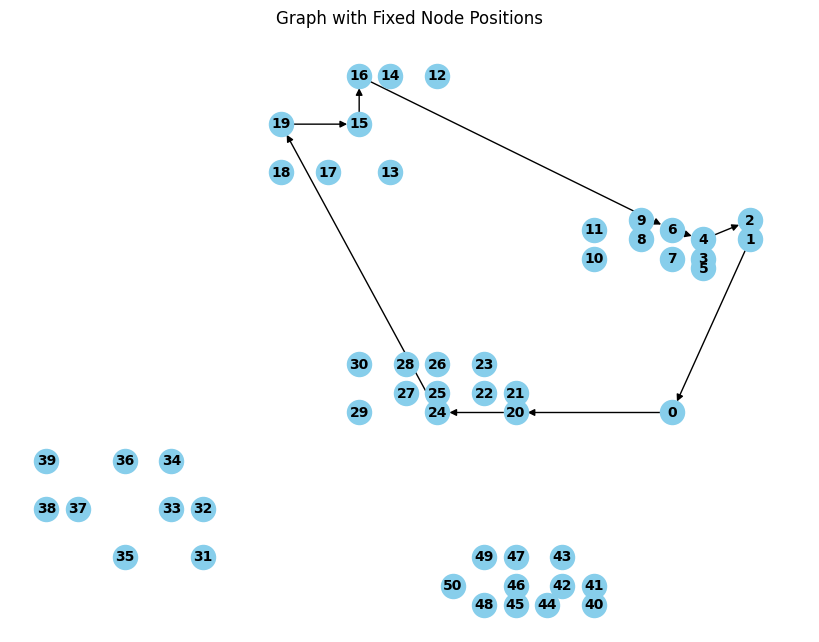

In [13]:
tour = [0,20,24,19,15,16,6,4,2,1]
edges = []
for i in range(tour[0], len(tour)-1):
    u  = tour[i]
    v = tour[i+1]
    
    edge = (u,v)
    edges.append(edge)
    
edges.append((1, 0))
tour_graph = graph.subgraph(tour)
plot_graph_with_positions(graph.nodes, edges)

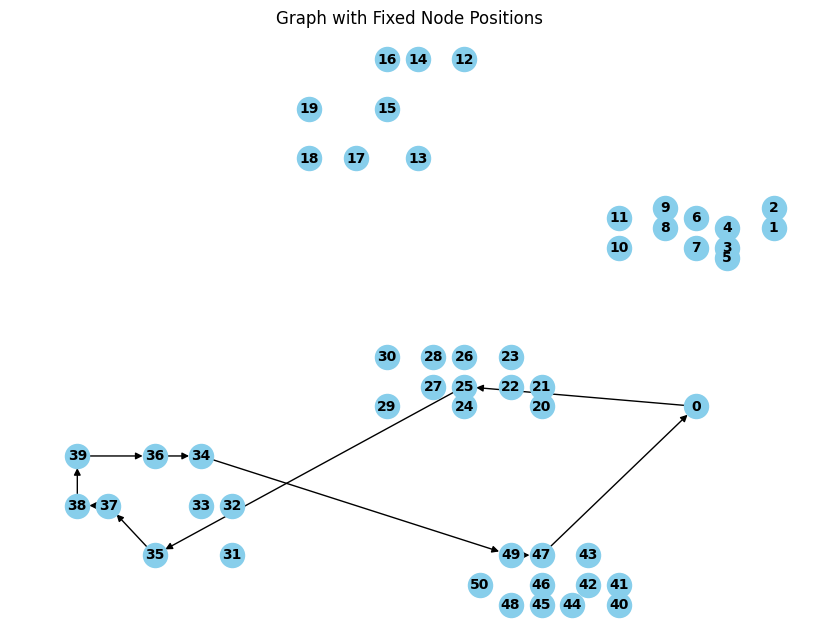

In [12]:
x_0_25 = 1.0
x_25_35 = 1.0
x_34_49 = 1.0
x_35_37 = 1.0
x_36_34 = 1.0
x_37_38 = 1.0
x_38_39 = 1.0
x_39_36 = 1.0
x_47_0 = 1.0
x_49_47 = 1.0

tour = [0, 25, 35, 37, 38, 39, 36, 34, 49, 47]

edges = []
for i in range(tour[0], len(tour)-1):
    u  = tour[i]
    v = tour[i+1]
    
    edge = (u,v)
    edges.append(edge)
    
edges.append((47, 0))
tour_graph = graph.subgraph(tour)
plot_graph_with_positions(graph.nodes, edges)

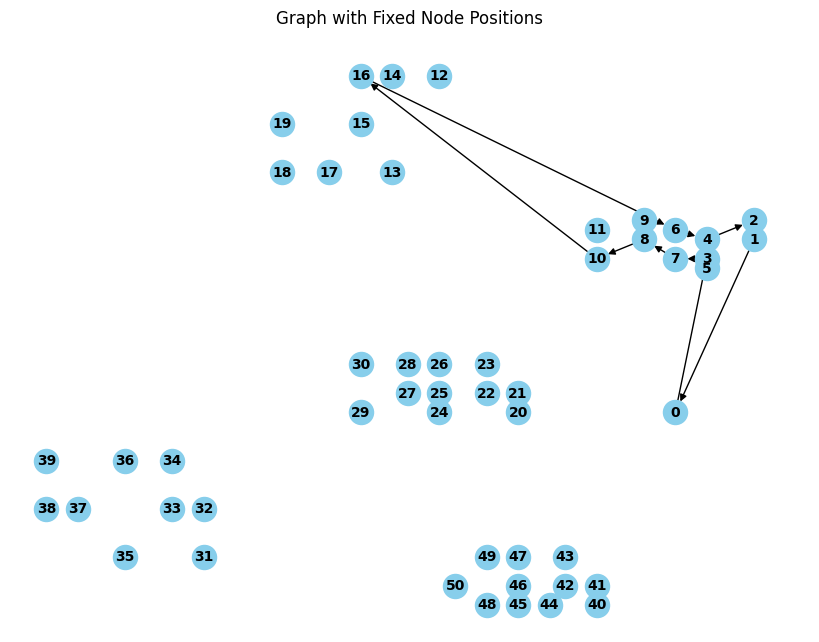

In [11]:
import networkx as nx



tour = [0, 3, 7, 8, 10, 16, 6, 4, 2, 1]
edges = []
for i in range(tour[0], len(tour)-1):
    u  = tour[i]
    v = tour[i+1]
    
    edge = (u,v)
    edges.append(edge)
    
edges.append((1, 0))
tour_graph = graph.subgraph(tour)
plot_graph_with_positions(graph.nodes, edges)

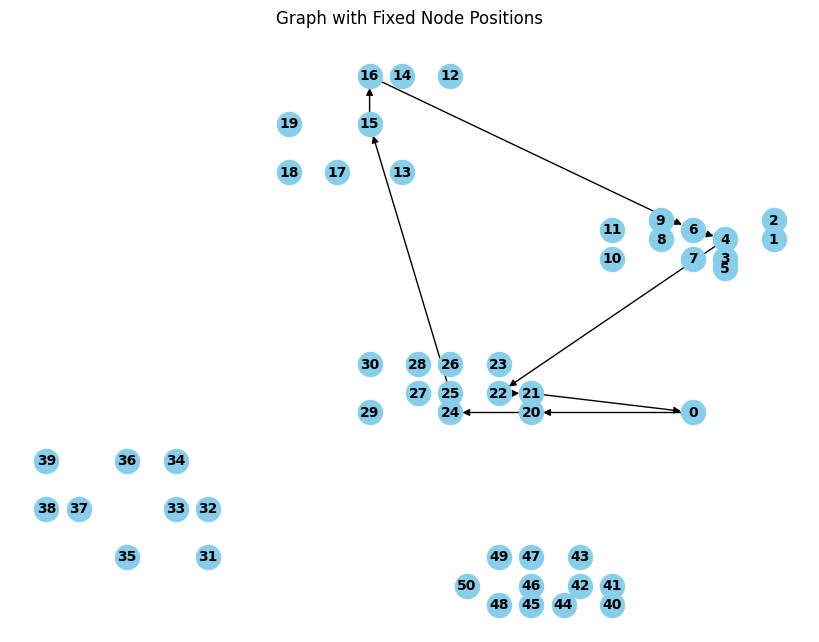

In [9]:
plot_graph_with_positions(graph.nodes, edges)

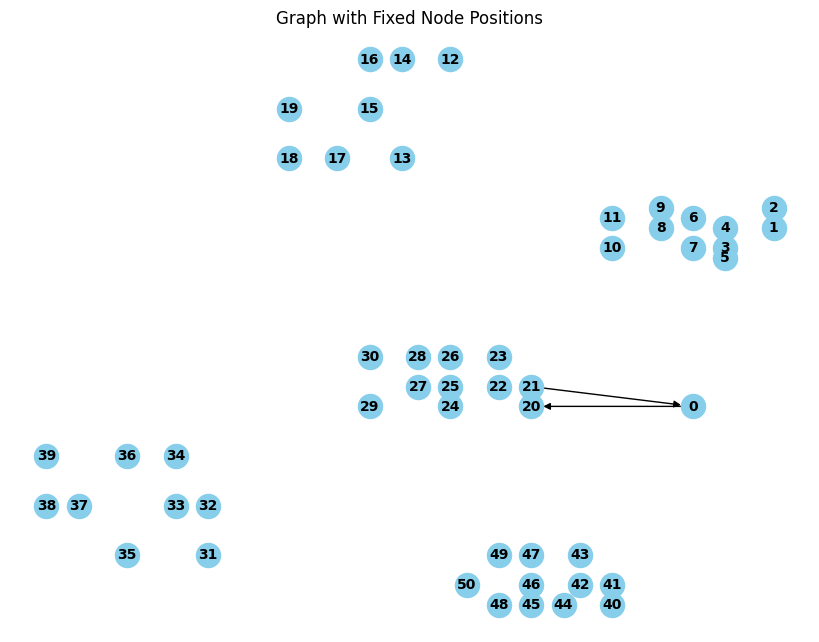

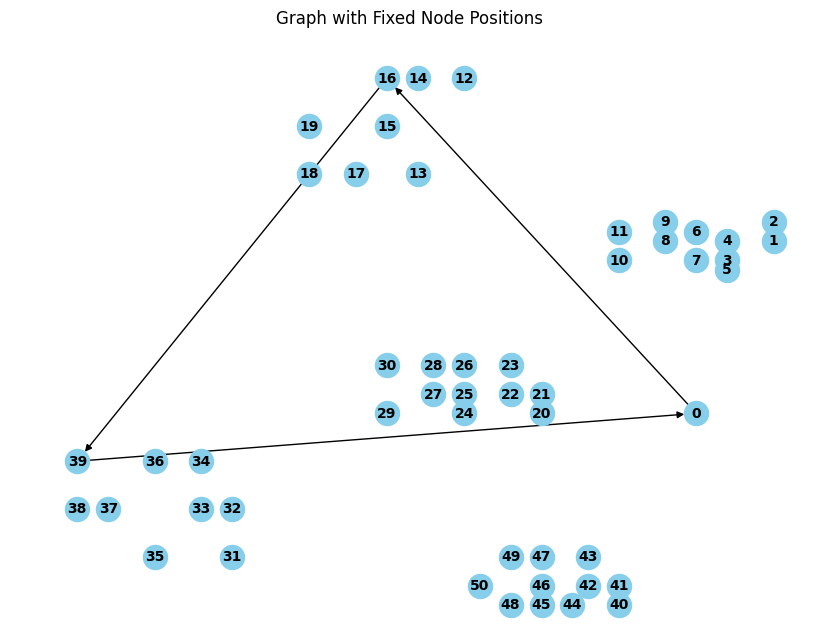

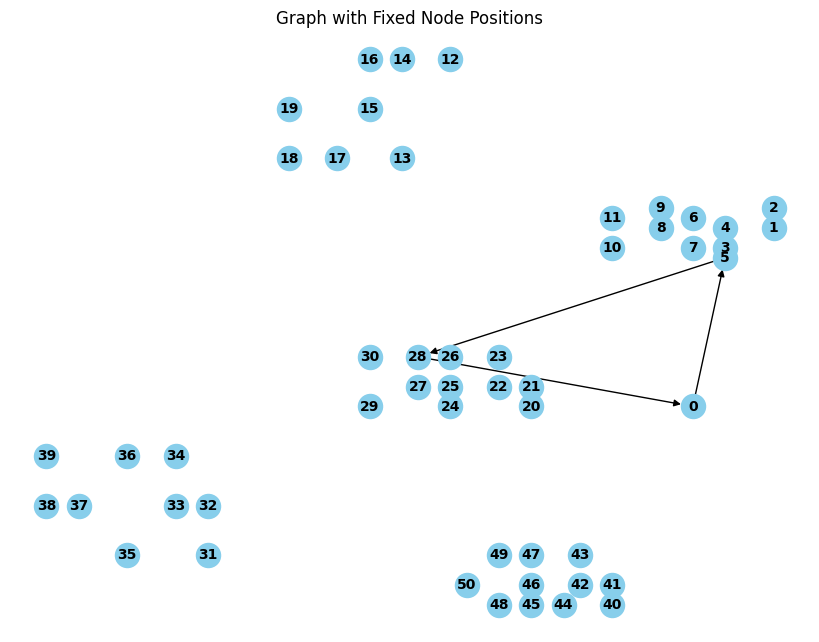

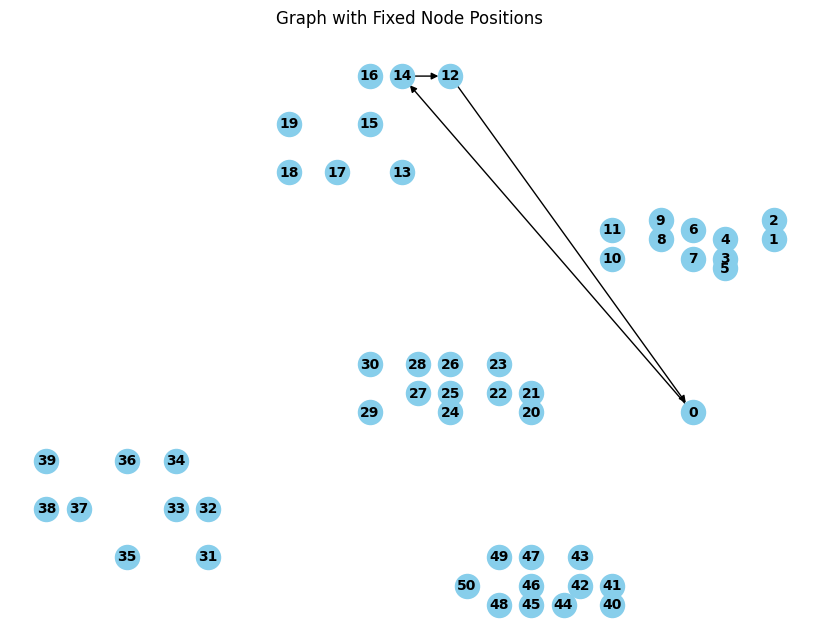

In [18]:
plot_graph_with_positions(graph.nodes, [(0,20),(20,21),(21,0)]) # T1
plot_graph_with_positions(graph.nodes, [(0,16),(16,39),(39,0)])
plot_graph_with_positions(graph.nodes, [(0,5),(5,28),(28,0)])
plot_graph_with_positions(graph.nodes, [(0,14),(14,12),(12,0)])